<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/dqe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: Compute DQE from simulated trjectories

# Resources
* Meyer, R. R., & Kirkland, A. (1998). The effects of electron and photon scattering on signal and noise transfer properties of scintillators in CCD cameras used for electron detection. Ultramicroscopy, 75(1), 23–33. http://doi.org/10.1016/S0304-3991(98)00051-5

* Meyer, R. R., & Kirkland, A. I. (2000). Characterisation of the signal and noise transfer of CCD cameras for electron detection. Microscopy Research and Technique, 49(3), 269–280. 

# Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
from scipy import ndimage
def doplt(arr2d):
  plt.imshow(arr2d,cmap='gray')

# Compute $DQE_s(u,v)$ from simulated trajectories
* A la Meyer & Kirkland (1998, 2000)
* simulated trajectories do not have any reference to an image. They are all on the same spot, and there is no signal dependence from the image.

Meyer & Kirkland use simulations from Joy's 1995 textbook on Monte Carlo simulations for electron microscopy (1995). In lieu of this treatment, for now I just made up some trajectories that looked similar to those in the figures (a random walk with random drift).

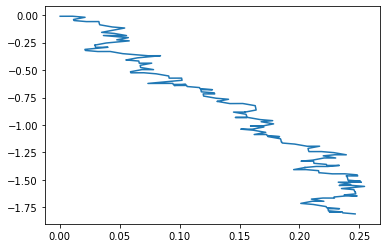

In [ ]:
dims = 2
step_n = 200
step_set = [-1, 0, 1]
origin = np.zeros((1,dims))
# Simulate steps in 2D
step_shape = (step_n,dims)
def sim_traj(step_set,step_shape,origin,step_n):
  steps = np.random.choice(a=step_set, size=step_shape)
  path = (np.concatenate([origin, steps])+np.random.uniform(low=-1,high=1,size=2)).cumsum(0) / step_n
  return(path)

path = sim_traj(step_set,step_shape,origin,step_n)*2
plt.plot(path[:,0],path[:,1])


## 1D

Note that the spacing of $(u,v)$ is from $(-0.5N/A, 0.5N/A]$ where $N$ is the number of pixels and $A$ is the box length in real space. The step size is $1/A$. We can assume a pixel size and then use real space image indeces to be in these distance units (e.g. a pixel size of 1 Anstrom and pixel (i,j) is 1 Anstrom from pixel (i+1,j)). With pixel size 1 Angstrom we have N/A=1

2.5249783805327324

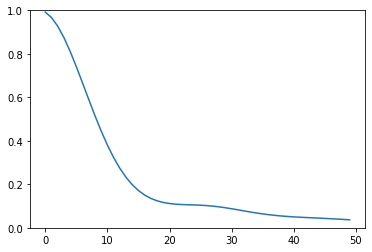

In [ ]:
n_sim = 500
nx=100
g_mu_u = np.zeros((nx,n_sim),dtype=np.complex64)
#us=np.linspace(-1/(nx//2),1/(nx//2),nx)#1/(np.arange(-nx//2,nx//2)+0.5)
us =np.arange(-.5,.5,1/nx)+1/nx # with pixel size 1 Angstrom we have N/A=1
std_path = np.zeros(n_sim)
for idx_sim in range(n_sim):
  path = sim_traj(step_set,step_shape,origin,step_n)*5
  std_path[idx_sim] = np.abs(path[:,0]).max()
  for idx_u in range(us.shape[0]):
    u = us[idx_u]
    g_mu_u[idx_u,idx_sim] += np.exp(-2j*np.pi*u*path[:,0]).sum()

up = np.abs(g_mu_u.mean(axis=1))**2
down = (np.abs(g_mu_u)**2).mean(axis=1)

dqe_s_1d = up / down
ax = pd.Series(dqe_s_1d[nx//2:]).plot()
ax.set_ylim(0,1)
std_path.mean()

## 2D

In [ ]:
n_sim = 500
nx=100
g_mu_u = np.zeros((nx,nx,n_sim),dtype=np.complex64)
#us=np.linspace(-1/(nx//2),1/(nx//2),nx)#1/(np.arange(-nx//2,nx//2)+0.5)
us = np.arange(-.5,.5,1/nx)+1/nx
vs = np.arange(-.5,.5,1/nx)+1/nx
std_path = np.zeros(n_sim)
for idx_sim in range(n_sim):
  path = sim_traj(step_set,step_shape,origin,step_n)*5
  std_path[idx_sim] = np.abs(path[:,0]).max()

  for idx_u in range(us.shape[0]):
    for idx_v in range(vs.shape[0]):
      g_mu_u[idx_u,idx_v,idx_sim] += np.exp(-2j*np.pi*(us[idx_u]*path[:,0] + vs[idx_v]*path[:,1])).sum()
      #g_mu_uv = np.exp(-2j*np.pi*(us[idx_u]*paths[:,0] + vs[idx_v]*paths[:,1])).reshape(n_sim,-1).sum(axis=1)



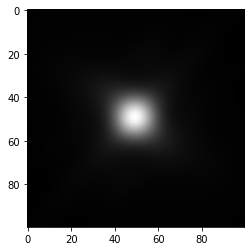

In [ ]:
up = np.abs(g_mu_u.mean(axis=-1))**2
doplt(up)

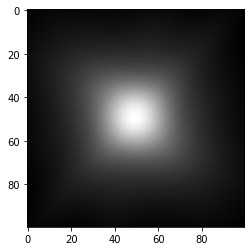

In [ ]:
down = (np.abs(g_mu_u)**2).mean(axis=-1)
doplt(down)

As we increase the number of simulations to the hundreds, we get radial symmetry. Meyer and Kirklands did two million simulated trajectories (Fig 8, Meyer & Kirkland, 2000).

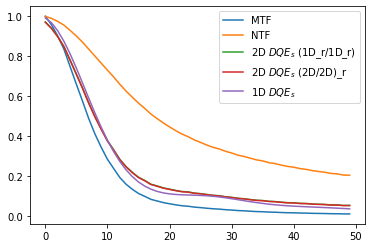

In [ ]:
# https://scipy-lectures.org/advanced/image_processing/auto_examples/plot_radial_mean.html

def setup_radial(arr2d,nbins=None):
  sx, sy = arr2d.shape
  X, Y = np.ogrid[0:sx, 0:sy]
  r = np.hypot(X - sx/2, Y - sy/2)
  if nbins is not None:
    rbin = (nbins* r/r.max()).astype(np.int)
  else:
    rbin = (r).astype(np.int)
  return(rbin)

def do_radial_average(arr2d,rbin,past_Nyquist=False):
  if past_Nyquist:
    index = np.arange(1, rbin.max() +1)
  else:
    index = np.arange(1, rbin.shape[0]//2 +1)
  radial_mean = ndimage.mean(arr2d, labels=rbin, index=index)
  return(radial_mean)

rbin = setup_radial(up)
up_r = do_radial_average(up,rbin)[:nx//2]
down_r = do_radial_average(down,rbin)[:nx//2]

pd.Series(up_r/up_r.max()).plot(label='MTF', legend=True)
pd.Series(down_r/down_r.max()).plot(label='NTF', legend=True)
pd.Series(up_r/down_r).plot(label=r'2D $DQE_s$ (1D_r/1D_r)', legend=True)
pd.Series(do_radial_average(up/down,rbin)[:nx//2]).plot(label=r'2D $DQE_s$ (2D/2D)_r', legend=True)
pd.Series(dqe_s_1d[-nx//2:]).plot(label=r'1D $DQE_s$', legend=True)



The trajectories give $g_\mu(x,y)$. To get the Fourier transform: $\hat g_\mu(u,v)$ for each trajectory, we compute $\sum_{p} \exp[-2 \pi i (x_p  u + y_p v)]$, ie Eq 20 in Meyer and Kirkland, 2000, where $(x_p,y_p)$ is the real space coordinate of the trajectory (photon detection in CCDs) from the simulation. These are the plus, diamonds and squares in Fig 2b in the paper. Because of the simulation we know the exact floating point value of $(x_p,y_p)$ and not just what pixel it happens in, and this is what the authors mean for “no sampling in real space takes place” (Meyer and Kirkland, 2000, p. 274).

The results I’m getting for the $DQE_s$ (just the scintillator, no pixellation effect from the detector) make physical sense: when the trajectories spread out more the DQE goes down at higher spatial frequency. The magnitude is intuitive: the DQE is near unity when the trajectories wander around on one pixel, but then the DQE drops off at high spatial frequency when the trajectories spread out over several pixels. If the trajectories spread over tens of pixels then the DQE drops very dramatically by 0.25 Nyquist or less. Furthermore, this trend doesn’t depend the total # of pixels in the detector. 